### Imports

In [38]:
from collections import defaultdict
import random
import numpy as np   
import scipy.linalg

import matplotlib.pyplot as plt

### Read in data

In [2]:
def read_txt(filename, start=0, end=100000000):
  
    u_i = defaultdict(set)
    i_u = defaultdict(set)
    labels = defaultdict(int)

    with open(filename, 'r') as f:
        count = 0
        for l in f:
            if count < start or count >= end:
                count += 1
                continue

            l = l.strip("\n").split()
            u = l[0]
            i = l[1]
            r = l[2]
            u_i[u].add((i,r))
            i_u[i].add((u,r))
            labels[(u,i)] = r
            count += 1

    return u_i, i_u, labels

#read in all data
b_u_i, b_i_u, b_labels = read_txt('books.txt')
e_u_i, e_i_u, e_labels = read_txt('electronics.txt')
m_u_i, m_i_u, m_labels = read_txt('movies.txt')

# get users and items list for all 3 datasets 
b_users = list(b_u_i.keys())
b_items = list(b_i_u.keys())

e_users = list(e_u_i.keys())
e_items = list(e_i_u.keys())

m_users = list(m_u_i.keys())
m_items = list(m_i_u.keys())

# randomly shuffle users and items 
random.shuffle(b_users)
random.shuffle(b_items)
random.shuffle(e_users)
random.shuffle(e_items)
random.shuffle(m_users)
random.shuffle(m_items)

# sort users and items by most popular 
b_u_counts = [(len(b_u_i[u]), str(u)) for u in b_users]
b_u_counts.sort(reverse=True)

b_i_counts = [(len(b_i_u[i]), i) for i in b_items]
b_i_counts.sort(reverse=True)

e_u_counts = [(len(e_u_i[u]), u) for u in e_users]
e_u_counts.sort(reverse=True)

e_i_counts = [(len(e_i_u[i]), i) for i in e_items]
e_i_counts.sort(reverse=True)

m_u_counts = [(len(m_u_i[u]), u) for u in m_users]
m_u_counts.sort(reverse=True)

m_i_counts = [(len(m_i_u[i]), i) for i in m_items]
m_i_counts.sort(reverse=True)

### Create training data 

In [3]:
M = 1000
N = 10000

# select 500 most popular users and 1000 most popular items 
b_u_train = [u[1] for u in b_u_counts[:M]]
b_i_train = [i[1] for i in b_i_counts[:N]]
e_u_train = [u[1] for u in e_u_counts[:M]]
e_i_train = [i[1] for i in e_i_counts[:N]]
m_u_train = [u[1] for u in m_u_counts[:M]]
m_i_train = [i[1] for i in m_i_counts[:N]]

### Ratings matrix & Train/test split 

In [4]:
# create 0 filled ratings matrices 
D_b = np.zeros((M,N))
D_e = np.zeros((M,N))
D_m = np.zeros((M,N))

b_pairs = []
e_pairs = []
m_pairs = []

b_user_count = defaultdict(int)
e_user_count = defaultdict(int)
m_user_count = defaultdict(int)

# create user,item rating pairs and populate ratings matrices
for a,u in enumerate(b_u_train): 
    for b,i in enumerate(b_i_train): 
        if (u,i) in b_labels: 
            b_pairs.append((u,i, a, b, float(b_labels[(u,i)])))
            b_user_count[u] += 1
        D_b[a,b] = float(b_labels[(u,i)])
        
for a,u in enumerate(e_u_train): 
    for b,i in enumerate(e_i_train): 
        if (u,i) in e_labels: 
            e_pairs.append((u,i, a, b, float(e_labels[(u,i)])))
            e_user_count[u] += 1
        D_e[a,b] = float(e_labels[(u,i)])
        
for a,u in enumerate(m_u_train): 
    for b,i in enumerate(m_i_train):
        if (u,i) in m_labels: 
            m_pairs.append((u,i, a, b, float(m_labels[(u,i)])))
            m_user_count[u] += 1
        D_m[a,b] = float(m_labels[(u,i)])
        
print("total number of book (user,item) pairs = %d" % (len(b_pairs)))
print("total number of electronics (user,item) pairs = %d" % (len(e_pairs)))
print("total number of movies (user,item) pairs = %d" % (len(m_pairs)))

# randomly shuffle user,item rating pairs 
random.shuffle(b_pairs)
random.shuffle(e_pairs)
random.shuffle(m_pairs)

b_user_train_count = defaultdict(int)
e_user_train_count = defaultdict(int)
m_user_train_count = defaultdict(int)

b_train_pairs = []
b_test_pairs = []

e_train_pairs = []
e_test_pairs = []

m_train_pairs = []
m_test_pairs = []

for b in b_pairs: 
    u = b[0]
    if b_user_train_count[u] < 0.8*b_user_count[u]: 
        b_user_train_count[u] += 1
        b_train_pairs.append(b)
    else: 
        b_test_pairs.append(b)
    
for e in e_pairs: 
    u = e[0]
    if e_user_train_count[u] < 0.8*e_user_count[u]: 
        e_user_train_count[u] += 1
        e_train_pairs.append(e)
    else: 
        e_test_pairs.append(e)
        
for m in m_pairs: 
    u = m[0]
    if m_user_train_count[u] < 0.8*m_user_count[u]: 
        m_user_train_count[u] += 1
        m_train_pairs.append(m)
    else: 
        m_test_pairs.append(m)

# split rating pairs into train/test 
# b_train_pairs = b_pairs[:int(len(b_pairs)*0.8)]
# b_test_pairs = b_pairs[int(len(b_pairs)*0.8):]

# e_train_pairs = e_pairs[:int(len(e_pairs)*0.8)]
# e_test_pairs = e_pairs[int(len(e_pairs)*0.8):]

# m_train_pairs = m_pairs[:int(len(m_pairs)*0.8)]
# m_test_pairs = m_pairs[int(len(m_pairs)*0.8):]


# remove test pair ratings from training rating matrix 
for b in b_test_pairs:  
    D_b[b[2],b[3]] = 0
for e in e_test_pairs: 
    D_e[e[2],e[3]] = 0
for m in m_test_pairs: 
    D_m[m[2],m[3]] = 0
    
    
print("total number of book (user,item) pairs = %d" % (len(b_pairs)))
print("book train size count = %d, percent = %f" % (len(b_train_pairs), len(b_train_pairs)/len(b_pairs)))
print("total number of electronics (user,item) pairs = %d" % (len(e_pairs)))
print("total number of movies (user,item) pairs = %d" % (len(m_pairs)))

total number of book (user,item) pairs = 120669
total number of electronics (user,item) pairs = 49811
total number of movies (user,item) pairs = 216677
total number of book (user,item) pairs = 120669
book train size count = 96930, percent = 0.803272
total number of electronics (user,item) pairs = 49811
total number of movies (user,item) pairs = 216677


### Train cluster level latent factor model 

In [45]:
# calculate mse based on predictions matrix and user,item rating pair 
def calc_mse(predictions, pairs, unseen_items=None): 
    error = 0
    count = 0
    for p in pairs: 
        error += (predictions[p[2],p[3]] - p[4])**2
        
        count += 1
    mse = error/count
    
    if unseen_items != None: 
        u_error = 0
        s_error = 0
        u_count = 0
        s_count = 0
        
        for p in pairs: 
            if p[1] in unseen_items: 
                u_error += (predictions[p[2],p[3]] - p[4])**2
                u_count += 1
            else: 
                s_error += (predictions[p[2],p[3]] - p[4])**2
                s_count += 1
        print("seen count = %d, unseen count = %d" % (s_count, u_count))
        print("seen mse = %f, unseen mse = %f" % (s_error/s_count, u_error/u_count))
    return mse

# train cluster level latent factor model
def train(K, L, T, D1, D2, epochs, train_pairs, test_pairs): 

    # K, number of user clusters
    # L, number of item clusters 
    # T, shared subspace
    # D1, ratings from domain 1: M1 x N1 
    # D2, ratings from domain 2: M2 x N2 
    
    # set mask matrices 
    W1 = (D1!=0).astype(int)
    W2 = (D2!=0).astype(int)
    
    M1 = D1.shape[0] # number of users in domain 1
    M2 = D2.shape[0] # number of users in domain 2
    N1 = D1.shape[1] # number of items in domain 1
    N2 = D1.shape[1] # number of items in domain 2

    # item clusters 
    L1 = L
    L2 = L

    # randomly initialize U, S, and V
    U1 = np.random.rand(M1, K) # M1 x K
    U2 = np.random.rand(M2, K) # M2 x K

    V1 = np.random.rand(N1, L1) # N1 x L1
    V2 = np.random.rand(N2, L2) # N2 x L2 

    S0 = np.random.rand(K, T) # K x T
    S1 = np.random.rand(K, L1-T) # K x L1-T
    S2 = np.random.rand(K, L2-T) # K x L2-T

    min_val_mse = 10000
    
    train_mses = []
    val_mses = []
    
    # train loop 
    for epoch in range(epochs): 
        
        # S1 update equation 
        # V11.T is the laste L1-T columns of V1

        S1 = S1 * np.sqrt((U1.T.dot(np.multiply(D1,W1)).dot(V1[:,T:]) )/
                                     (U1.T.dot(np.multiply(U1.dot(S0).dot(V1[:,:T].T),W1) ).dot(V1[:,T:]) 
                                      + U1.T.dot(np.multiply(U1.dot(S1).dot(V1[:,T:].T),W1) ).dot(V1[:,T:])))
        # S2 update equation 
        S2 = S2 * np.sqrt((U2.T.dot(np.multiply(D2,W2)).dot(V2[:,T:]) )/
                          (U2.T.dot(np.multiply(U2.dot(S0).dot(V2[:,:T].T),W2) ).dot(V2[:,T:]) 
                                      + U2.T.dot(np.multiply(U2.dot(S2).dot(V2[:,T:].T),W2) ).dot(V2[:,T:])))

        # S0 update equation 
        A = (U1.T.dot(np.multiply(U1.dot(S0).dot(V1[:,:T].T),W1) ).dot(V1[:,:T]) 
                                      + U1.T.dot(np.multiply(U1.dot(S1).dot(V1[:,T:].T),W1) ).dot(V1[:,:T]))
        B = (U2.T.dot(np.multiply(U2.dot(S0).dot(V2[:,:T].T),W2) ).dot(V2[:,:T]) 
                                      + U2.T.dot(np.multiply(U2.dot(S2).dot(V2[:,T:].T),W2) ).dot(V2[:,:T]))
        S0 = S0 * np.sqrt( (U1.T.dot(np.multiply(D1,W1)).dot(V1[:,:T]) ) + (U2.T.dot(np.multiply(D2,W2)).dot(V2[:,:T]) ) / (A+B))

        # U1 update equation 
        a = np.multiply(D1, W1).dot(V1).dot(np.concatenate((S0,S1), axis=1).T)
        b = np.multiply(U1.dot(np.concatenate((S0,S1), axis=1)).dot(V1.T),W1).dot(V1).dot(np.concatenate((S0,S1),axis=1).T)
        U1 = U1 * np.sqrt(np.divide(a, b, out=np.zeros_like(a), where=b!=0))

        # U2 update equation
        a = np.multiply(D2, W2).dot(V2).dot(np.concatenate((S0,S2), axis=1).T)
        b = np.multiply(U2.dot(np.concatenate((S0,S2), axis=1)).dot(V2.T),W2).dot(V2).dot(np.concatenate((S0,S2),axis=1).T)
        U2 = U2 * np.sqrt(np.divide(a, b, out=np.zeros_like(a), where=b!=0))


        # V1 update equation 
        a = np.concatenate((S0,S1),axis=1).T.dot(U1.T).dot(np.multiply(D1,W1))
        b = np.concatenate((S0,S1),axis=1).T.dot(U1.T).dot(np.multiply(U1.dot(np.concatenate((S0,S1),axis=1)).dot(V1.T),W1))
        V1 = V1 * np.sqrt(np.divide(a,b, out=np.zeros_like(a), where=b!=0)).T

        # V2 update equation 
        a = np.concatenate((S0,S2),axis=1).T.dot(U2.T).dot(np.multiply(D2,W2))
        b = np.concatenate((S0,S2),axis=1).T.dot(U2.T).dot(np.multiply(U2.dot(np.concatenate((S0,S2),axis=1)).dot(V2.T),W2))
        V2 = V2 * np.sqrt(np.divide(a,b, out=np.zeros_like(a), where=b!=0)).T
        
        # D1_predictions = U1.dot(np.concatenate((S0,S1), axis=1)).dot(V1.T)
        
        # make predictions on D2 
        D2_predictions = U2.dot(np.concatenate((S0,S2), axis=1)).dot(V2.T)
        
        # get mse for train and test set 
        train_mse = calc_mse(D2_predictions, train_pairs)
        test_mse = calc_mse(D2_predictions, test_pairs)
        
        train_mses.append(train_mse)
        val_mses.append(test_mse)
        
        
        if test_mse < min_val_mse: 
            min_val_mse = test_mse 
        
        # report results 
        print("epoch = %d, train mse = %.4f, test mse = %.4f" % (epoch, train_mse, test_mse))
    
    plt.figure()
    plt.plot(range(len(train_mses)), train_mses)
    plt.plot(range(len(val_mses)), val_mses)
    plt.ylim(0,1)
    plt.show()
    return U1, U2, S0, S1, S2, V1, V2

In [46]:
K = 10 # user clusters 
L = 10 # number of item clusters 
T = 2 # shared subspace 


epoch = 0, train mse = 123.6774, test mse = 120.2770
epoch = 1, train mse = 114.1397, test mse = 111.2129
epoch = 2, train mse = 26.8900, test mse = 27.4890
epoch = 3, train mse = 4.6159, test mse = 5.9734
epoch = 4, train mse = 1.1081, test mse = 2.5095
epoch = 5, train mse = 0.6545, test mse = 2.0329
epoch = 6, train mse = 0.5996, test mse = 1.9660
epoch = 7, train mse = 0.5917, test mse = 1.9544
epoch = 8, train mse = 0.5891, test mse = 1.9513
epoch = 9, train mse = 0.5873, test mse = 1.9501
epoch = 10, train mse = 0.5857, test mse = 1.9492
epoch = 11, train mse = 0.5843, test mse = 1.9486
epoch = 12, train mse = 0.5829, test mse = 1.9480
epoch = 13, train mse = 0.5817, test mse = 1.9474
epoch = 14, train mse = 0.5805, test mse = 1.9468
epoch = 15, train mse = 0.5793, test mse = 1.9463
epoch = 16, train mse = 0.5782, test mse = 1.9458
epoch = 17, train mse = 0.5771, test mse = 1.9454
epoch = 18, train mse = 0.5761, test mse = 1.9449
epoch = 19, train mse = 0.5751, test mse = 1.9446


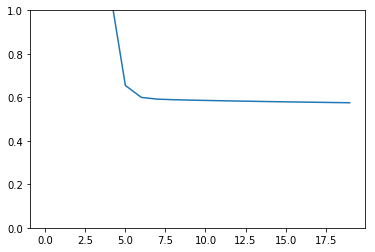

epoch = 0, train mse = 152.6565, test mse = 147.9412
epoch = 1, train mse = 131.8658, test mse = 127.9991
epoch = 2, train mse = 29.2237, test mse = 29.6352
epoch = 3, train mse = 4.7550, test mse = 6.0701
epoch = 4, train mse = 1.0692, test mse = 2.4521
epoch = 5, train mse = 0.6310, test mse = 1.9959


In [ ]:
U1, U2, S0, S1, S2, V1, V2 = train(K, L, T, D_b, D_e, 20, e_train_pairs, e_test_pairs)
U1, U2, S0, S1, S2, V1, V2 = train(K, L, T, D_m, D_e, 20, e_train_pairs, e_test_pairs)

In [36]:
U1, U2, S0, S1, S2, V1, V2 = train(K, L, T, D_m, D_b, 20, b_train_pairs, b_test_pairs)
U1, U2, S0, S1, S2, V1, V2 = train(K, L, T, D_e, D_b, 20, b_train_pairs, b_test_pairs)

epoch = 0, train mse = 146.7052, test mse = 145.9310
epoch = 1, train mse = 125.3002, test mse = 124.7120
epoch = 2, train mse = 27.7154, test mse = 27.8103
epoch = 3, train mse = 4.5596, test mse = 4.7956
epoch = 4, train mse = 1.0774, test mse = 1.3254
epoch = 5, train mse = 0.6314, test mse = 0.8780
epoch = 6, train mse = 0.5729, test mse = 0.8186
epoch = 7, train mse = 0.5631, test mse = 0.8085
epoch = 8, train mse = 0.5602, test mse = 0.8057
epoch = 9, train mse = 0.5586, test mse = 0.8042
epoch = 10, train mse = 0.5573, test mse = 0.8031
epoch = 11, train mse = 0.5562, test mse = 0.8021
epoch = 12, train mse = 0.5551, test mse = 0.8012
epoch = 13, train mse = 0.5542, test mse = 0.8003
epoch = 14, train mse = 0.5533, test mse = 0.7996
epoch = 15, train mse = 0.5524, test mse = 0.7988
epoch = 16, train mse = 0.5516, test mse = 0.7981
epoch = 17, train mse = 0.5509, test mse = 0.7975
epoch = 18, train mse = 0.5502, test mse = 0.7969
epoch = 19, train mse = 0.5495, test mse = 0.7963


In [37]:
U1, U2, S0, S1, S2, V1, V2 = train(K, L, T, D_b, D_m, 20, m_train_pairs, m_test_pairs)
U1, U2, S0, S1, S2, V1, V2 = train(K, L, T, D_e, D_m, 20, m_train_pairs, m_test_pairs)

epoch = 0, train mse = 113.9956, test mse = 113.4179
epoch = 1, train mse = 97.7454, test mse = 97.6504
epoch = 2, train mse = 22.7359, test mse = 22.8950
epoch = 3, train mse = 4.1601, test mse = 4.3208
epoch = 4, train mse = 1.2698, test mse = 1.4154
epoch = 5, train mse = 0.8562, test mse = 0.9952
epoch = 6, train mse = 0.7829, test mse = 0.9196
epoch = 7, train mse = 0.7640, test mse = 0.8998
epoch = 8, train mse = 0.7570, test mse = 0.8923
epoch = 9, train mse = 0.7536, test mse = 0.8886
epoch = 10, train mse = 0.7517, test mse = 0.8865
epoch = 11, train mse = 0.7505, test mse = 0.8852
epoch = 12, train mse = 0.7497, test mse = 0.8843
epoch = 13, train mse = 0.7492, test mse = 0.8837
epoch = 14, train mse = 0.7488, test mse = 0.8833
epoch = 15, train mse = 0.7485, test mse = 0.8829
epoch = 16, train mse = 0.7482, test mse = 0.8827
epoch = 17, train mse = 0.7480, test mse = 0.8825
epoch = 18, train mse = 0.7479, test mse = 0.8823
epoch = 19, train mse = 0.7477, test mse = 0.8822
ep

In [11]:

b_i_train_seen = set()

for b in b_train_pairs: 
    b_i_train_seen.add(b[1])
    
b_i_test_seen = set()

for b in b_test_pairs: 
    b_i_test_seen.add(b[1])
    
b_i_unseen = b_i_test_seen.difference(b_i_train_seen)



m_i_train_seen = set()

for m in m_train_pairs: 
    m_i_train_seen.add(m[1])
    
m_i_test_seen = set()

for m in m_test_pairs: 
    m_i_test_seen.add(m[1])
    
m_i_unseen = m_i_test_seen.difference(m_i_train_seen)




D2_predictions = U2.dot(np.concatenate((S0,S2), axis=1)).dot(V2.T)
        
# get mse for train and test set 
#train_mse = calc_mse(D2_predictions, train_pairs)
test_mse = calc_mse(D2_predictions, m_test_pairs, m_i_unseen)

# report results 
print("test mse = %.4f" % (test_mse))

seen count = 42864, unseen count = 75
seen mse = 0.848258, unseen mse = 19.573333
test mse = 0.8810


In [12]:
print(len(m_i_unseen))
print(len(m_i_train_seen))

55
9826


In [13]:
m_i_union = m_i_test_seen.union(m_i_train_seen)

In [14]:
print(len(m_i_union))

9881


In [15]:
print(len(b_train_pairs))
print(len(b_test_pairs))

print(len(m_train_pairs))
print(len(m_test_pairs))

print(len(e_train_pairs))
print(len(e_test_pairs))

96930
23739
173738
42939
40261
9550


In [16]:
a = len(m_i_train_seen.difference(m_i_test_seen))
b = len(m_i_train_seen.intersection(m_i_test_seen))
c = len(m_i_test_seen.difference(m_i_train_seen))

In [17]:
a = len(b_i_train_seen.difference(b_i_test_seen))
b = len(b_i_train_seen.intersection(b_i_test_seen))
c = len(b_i_test_seen.difference(b_i_train_seen))

In [18]:
print(a)
print(b)
print(c)
print(a+b+c)

2011
7539
117
9667


In [19]:
D2_predictions = U2.dot(np.concatenate((S0,S2), axis=1)).dot(V2.T)
        
# get mse for train and test set 
#train_mse = calc_mse(D2_predictions, train_pairs)
test_mse = calc_mse(D2_predictions, b_test_pairs, b_i_unseen)

# report results 
print("test mse = %.4f" % (test_mse))

seen count = 23591, unseen count = 148
seen mse = 1.720318, unseen mse = 1.866233
test mse = 1.7212


In [20]:
print(len(b_i_train_seen))
print(len(b_i_test_seen))

9550
7656


In [ ]:
147/23592

In [ ]:
print(len(b_test_pairs))